In [ ]:
!pip install tensorboardX
!pip install tensorboard


In [85]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tensorboardX import SummaryWriter
import numpy as np
import torchvision
import torchvision.transforms as transforms
import os
from sklearn.metrics import confusion_matrix
import numpy as np

In [81]:
from tensorboard import notebook

In [70]:
# Define your data transforms
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize the image to 28x28 pixels
    transforms.ToTensor(),        # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the pixel values to the range [-1, 1]
])

In [ ]:
# Define a transform to preprocess the data (convert to tensors and normalize)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Download and load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Define the size of the validation set
valid_size = 0.24  # You can adjust this value based on your needs

# Calculate the number of examples for the validation set
num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))

# Shuffle the indices to create a randomized split
np.random.shuffle(indices)

# Split the indices into training and validation sets
train_idx, valid_idx = indices[split:], indices[:split]

# Define data loaders for training, validation, and testing
batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, sampler=torch.utils.data.SubsetRandomSampler(train_idx))
val_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, sampler=torch.utils.data.SubsetRandomSampler(valid_idx))
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Function to convert labels to one-hot encodings
def one_hot_encode(labels, num_classes):
    return torch.eye(num_classes)[labels]

100%|██████████| 9912422/9912422 [00:00<00:00, 215010452.95it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 68788014.66it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 76256066.03it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 1849565.90it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
y = 0
for i,x in enumerate(train_loader):
  print(i,x[0].shape,x[1].shape)
  y = x
  if (i==0):
    break

0 torch.Size([64, 1, 28, 28]) torch.Size([64])


In [ ]:
def one_hot_encode(labels, num_classes):
    #print(torch.eye(num_classes)[labels].shape)
    return torch.eye(num_classes)[labels]

# Example of how to use the one_hot_encode function
num_classes = 10  # MNIST has 10 classes (0 to 9)
labels = y[1][0]
one_hot_labels = one_hot_encode(labels, num_classes)
print(one_hot_labels)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])


In [88]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_sizes, output_size):
        # Initialize network architecture
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.num_layers = len(hidden_sizes) + 1

        # Initialize weights and biases for all layers
        self.weights = [np.random.randn(input_size, hidden_sizes[0])]
        self.biases = [np.zeros((1, hidden_sizes[0]))]
        for i in range(len(hidden_sizes) - 1):
            self.weights.append(np.random.randn(hidden_sizes[i], hidden_sizes[i+1]))
            self.biases.append(np.zeros((1, hidden_sizes[i+1])))
        self.weights.append(np.random.randn(hidden_sizes[-1], output_size))
        self.biases.append(np.zeros((1, output_size)))
        self.total_loss = 0
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x))  # Subtracting the max for numerical stability
        return exp_x / exp_x.sum(axis=1, keepdims=True)

    def forward_pass(self, X):
        activations = [X]
        for i in range(self.num_layers):
            z = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            if i == self.num_layers - 1:
                output = self.softmax(z)
                activations.append(output)
            else:
                activation = self.sigmoid(z)
                activations.append(activation)
        return activations

    def cross_entropy_loss(self, y_true, y_pred):
        epsilon = 1e-15  # Small constant to avoid log(0)
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        x = - y_true * np.log(y_pred)
        #print(type(y_true),type(y_pred),type(x))
        return np.sum(x, axis=1).mean()  # Calculate the mean loss


    def backward_pass(self, X, y_true, activations):
        gradients = []
        delta = activations[-1] - y_true
        for i in range(self.num_layers - 1, -1, -1):
            #print(i)
            if i == self.num_layers - 1:
                dW = np.dot(activations[i].T, delta)
                db = np.sum(delta, axis=0, keepdims=True)
            else:
                delta = np.dot(delta, self.weights[i+1].T)
                delta = delta* activations[i+1] * (1 - activations[i+1])
                dW = np.dot(activations[i].T, delta)
                db = np.sum(delta, axis=0, keepdims=True)
            gradients.insert(0, (dW, db))
        return  gradients

    def update_weights(self, gradients, learning_rate):
        for i in range(self.num_layers):
            self.weights[i] -= learning_rate * gradients[i][0]
            self.biases[i] -= learning_rate * gradients[i][1]

    def train(self, X_batch, y_batch, learning_rate):
        total_loss = 0
        activations = self.forward_pass(X_batch)
        #print(type(X_batch),type(y_batch))
        loss = self.cross_entropy_loss(y_batch, activations[-1])
        #print(loss)
        gradients = self.backward_pass(X_batch, y_batch, activations)
        self.update_weights(gradients, learning_rate)
        self.total_loss += loss
        total_loss += loss
        average_loss = total_loss / len(X_batch)
        #print(f"Loss: {average_loss:.4f}")

    def validate(self, X_batch, y_batch):
        total_loss = 0
        activations = self.forward_pass(X_batch)
        #print(type(X_batch),type(y_batch))
        loss = self.cross_entropy_loss(y_batch, activations[-1])
        #print(loss)
        #gradients = self.backward_pass(X_batch, y_batch, activations)
        #self.update_weights(gradients, learning_rate)
        self.total_loss += loss
        total_loss += loss
        average_loss = total_loss / len(X_batch)

    def predict(self, X):
        activations = self.forward_pass(X)
        #loss = self.cross_entropy_loss(y_batch, activations[-1])
        return np.argmax(activations[-1], axis=1)



Epoch 1/15, Train Loss: 1.2769
Epoch 1/15, Val Loss: 0.5755
Epoch 2/15, Train Loss: 0.5306
Epoch 2/15, Val Loss: 0.4489
Epoch 3/15, Train Loss: 0.4326
Epoch 3/15, Val Loss: 0.4053
Epoch 4/15, Train Loss: 0.3603
Epoch 4/15, Val Loss: 0.3248
Epoch 5/15, Train Loss: 0.3165
Epoch 5/15, Val Loss: 0.3186
Epoch 6/15, Train Loss: 0.2938
Epoch 6/15, Val Loss: 0.3428
Epoch 7/15, Train Loss: 0.2778
Epoch 7/15, Val Loss: 0.2954
Epoch 8/15, Train Loss: 0.2450
Epoch 8/15, Val Loss: 0.2802
Epoch 9/15, Train Loss: 0.2291
Epoch 9/15, Val Loss: 0.2737
Epoch 10/15, Train Loss: 0.2120
Epoch 10/15, Val Loss: 0.2610
Epoch 11/15, Train Loss: 0.2013
Epoch 11/15, Val Loss: 0.2453
Epoch 12/15, Train Loss: 0.1880
Epoch 12/15, Val Loss: 0.2333
Epoch 13/15, Train Loss: 0.1841
Epoch 13/15, Val Loss: 0.2329
Epoch 14/15, Train Loss: 0.1732
Epoch 14/15, Val Loss: 0.2312
Epoch 15/15, Train Loss: 0.1624
Epoch 15/15, Val Loss: 0.2253


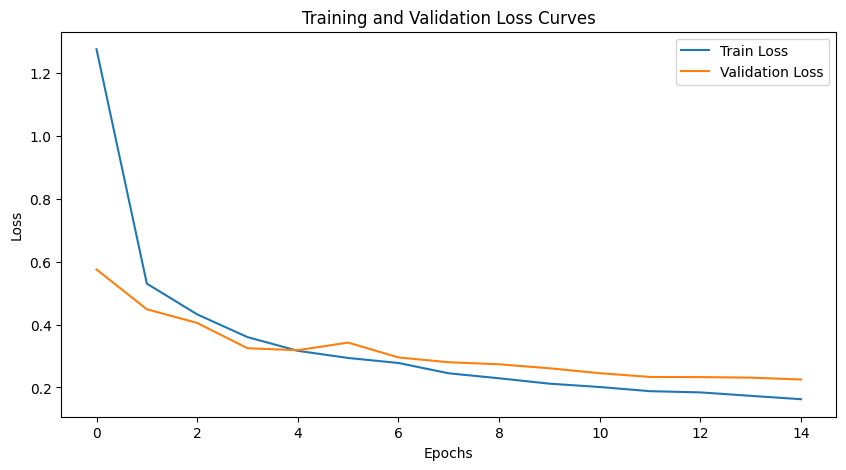

Test Accuracy: 93.60%


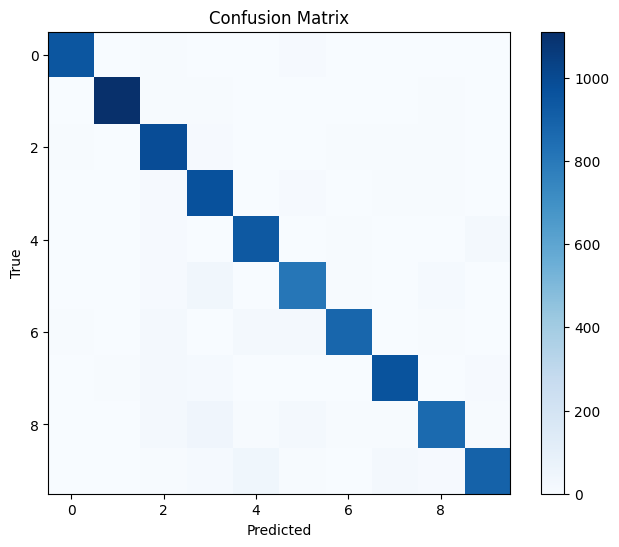

In [89]:
# Constants
input_size = 28 * 28
hidden_sizes = [500, 250, 100]
output_size = 10
learning_rate = 0.01
epochs = 15

# Constants
activation_function = "relu"  # Replace with the actual activation function used


# Create a unique directory name based on activation function and learning rate
log_dir = f"logs/{activation_function}_lr{learning_rate:.4f}"

# Make sure the logs directory exists
os.makedirs(log_dir, exist_ok=True)

# Initialize the SummaryWriter with the unique log directory
writer = SummaryWriter(log_dir=log_dir)
# Create your NeuralNetwork model
model = NeuralNetwork(input_size, hidden_sizes, output_size)

# Assuming you have defined train_loader and test_loader

# Create a list to store training and validation losses
train_losses = []
val_losses = []

# Training loop
for epoch in range(epochs):
    total_loss = 0
    for batch_images, batch_labels in train_loader:
        # Flatten the batch_images
        batch_images = batch_images.view(-1, input_size).numpy()
        # One-hot encode the batch_labels
        batch_labels_onehot = one_hot_encode(batch_labels, output_size).numpy()
        # Train the model on the batch
        model.train(batch_images, batch_labels_onehot, learning_rate)

    average_loss = model.total_loss / len(train_loader)
    model.total_loss = 0
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {average_loss:.4f}")

    # Log the training loss to TensorBoard and store it in the list
    writer.add_scalar('Loss/Train', average_loss, epoch)
    train_losses.append(average_loss)

    # Validation loop
    total_val_loss = 0
    num_val_batches = len(val_loader)

    for val_batch_images, val_batch_labels in val_loader:
        # Get predictions from the model
        val_batch_images = val_batch_images.view(-1, input_size).numpy()
        val_batch_labels_onehot = one_hot_encode(val_batch_labels, output_size).numpy()
        model.validate(val_batch_images, val_batch_labels_onehot)

    average_val_loss = model.total_loss / len(val_loader)
    model.total_loss = 0
    print(f"Epoch {epoch + 1}/{epochs}, Val Loss: {average_val_loss:.4f}")

    # Log the validation loss to TensorBoard and store it in the list
    writer.add_scalar('Loss/Validation', average_val_loss, epoch)
    val_losses.append(average_val_loss)

# Close the SummaryWriter
writer.close()

# Plotting training and validation loss curves
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Curves')
plt.savefig(os.path.join(log_dir, 'loss_plot.png'))
plt.show()

# Testing loop
correct = 0
total = 0
true_labels = []
predicted_labels = []

for batch_images, batch_labels in test_loader:
    batch_images = batch_images.view(-1, input_size).numpy()
    batch_labels_onehot = one_hot_encode(batch_labels, output_size).numpy()

    # Get predictions from the model
    predictions = model.predict(batch_images)
    true_labels.extend(batch_labels.numpy())
    predicted_labels.extend(predictions)

    # Calculate accuracy
    total += batch_labels.size(0)
    correct += (predictions == batch_labels.numpy()).sum().item()

accuracy = (100 * correct / total)
print(f"Test Accuracy: {accuracy:.2f}%")

# Generate and display the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig(os.path.join(log_dir, 'confusion_matrix.png'))
plt.show()

In [96]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_sizes, output_size):
        # Initialize network architecture
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.num_layers = len(hidden_sizes) + 1

        # Initialize weights and biases for all layers using Glorot initialization
        self.weights = []
        self.biases = []
        for i in range(len(hidden_sizes) + 1):
            if i == 0:
                M = np.sqrt(6.0 / (input_size + hidden_sizes[i]))
                self.weights.append(np.random.uniform(-M, M, size=(input_size, hidden_sizes[i])))
            elif i == len(hidden_sizes):
                M = np.sqrt(6.0 / (hidden_sizes[i - 1] + output_size))
                self.weights.append(np.random.uniform(-M, M, size=(hidden_sizes[i - 1], output_size)))
            else:
                M = np.sqrt(6.0 / (hidden_sizes[i - 1] + hidden_sizes[i]))
                self.weights.append(np.random.uniform(-M, M, size=(hidden_sizes[i - 1], hidden_sizes[i])))
            if i == len(hidden_sizes):
              bias_vector = np.zeros((1,self.output_size ))
            else:
              bias_vector = np.zeros((1, hidden_sizes[i]))
            self.biases.append(bias_vector)

        self.total_loss = 0
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x))  # Subtracting the max for numerical stability
        return exp_x / exp_x.sum(axis=1, keepdims=True)

    def forward_pass(self, X):
        activations = [X]
        for i in range(self.num_layers):
            z = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            if i == self.num_layers - 1:
                output = self.softmax(z)
                activations.append(output)
            else:
                activation = self.sigmoid(z)
                activations.append(activation)
        return activations

    def cross_entropy_loss(self, y_true, y_pred):
        epsilon = 1e-15  # Small constant to avoid log(0)
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        x = - y_true * np.log(y_pred)
        #print(type(y_true),type(y_pred),type(x))
        loss = np.sum(x, axis=1).mean()
        #print(x.shape,loss)
        return loss  # Calculate the mean loss


    def backward_pass(self, X, y_true, activations):
        gradients = []
        delta = activations[-1] - y_true
        for i in range(self.num_layers - 1, -1, -1):
            #print(i)
            if i == self.num_layers - 1:
                dW = np.dot(activations[i].T, delta)
                db = np.sum(delta, axis=0, keepdims=True)
            else:
                delta = np.dot(delta, self.weights[i+1].T)
                delta = delta* activations[i+1] * (1 - activations[i+1])
                dW = np.dot(activations[i].T, delta)
                db = np.sum(delta, axis=0, keepdims=True)
            gradients.insert(0, (dW, db))
        return gradients

    def update_weights(self, gradients, learning_rate):
        for i in range(self.num_layers):
            self.weights[i] -= learning_rate * gradients[i][0]
            self.biases[i] -= learning_rate * gradients[i][1]

    def train(self, X_batch, y_batch, learning_rate):
        total_loss = 0
        activations = self.forward_pass(X_batch)
        #print(type(X_batch),type(y_batch))
        loss = self.cross_entropy_loss(y_batch, activations[-1])
        #print(loss)
        gradients = self.backward_pass(X_batch, y_batch, activations)
        self.update_weights(gradients, learning_rate)
        self.total_loss += loss
        total_loss += loss
        average_loss = total_loss / len(X_batch)
        #print(f"Loss: {average_loss:.4f}")

    def validate(self, X_batch, y_batch):
        total_loss = 0
        activations = self.forward_pass(X_batch)
        #print(type(X_batch),type(y_batch))
        loss = self.cross_entropy_loss(y_batch, activations[-1])
        #print(loss)
        #gradients = self.backward_pass(X_batch, y_batch, activations)
        #self.update_weights(gradients, learning_rate)
        self.total_loss += loss
        total_loss += loss
        average_loss = total_loss / len(X_batch)

    def predict(self, X):
        activations = self.forward_pass(X)
        #loss = self.cross_entropy_loss(y_batch, activations[-1])
        return np.argmax(activations[-1], axis=1)


Epoch 1/15, Train Loss: 0.8640
Epoch 1/15, Val Loss: 0.3002
Epoch 2/15, Train Loss: 0.2778
Epoch 2/15, Val Loss: 0.2072
Epoch 3/15, Train Loss: 0.1949
Epoch 3/15, Val Loss: 0.1762
Epoch 4/15, Train Loss: 0.1523
Epoch 4/15, Val Loss: 0.1481
Epoch 5/15, Train Loss: 0.1234
Epoch 5/15, Val Loss: 0.1340
Epoch 6/15, Train Loss: 0.1027
Epoch 6/15, Val Loss: 0.1260
Epoch 7/15, Train Loss: 0.0877
Epoch 7/15, Val Loss: 0.1081
Epoch 8/15, Train Loss: 0.0753
Epoch 8/15, Val Loss: 0.0972
Epoch 9/15, Train Loss: 0.0653
Epoch 9/15, Val Loss: 0.1323
Epoch 10/15, Train Loss: 0.0580
Epoch 10/15, Val Loss: 0.0921
Epoch 11/15, Train Loss: 0.0515
Epoch 11/15, Val Loss: 0.0864
Epoch 12/15, Train Loss: 0.0425
Epoch 12/15, Val Loss: 0.1113
Epoch 13/15, Train Loss: 0.0386
Epoch 13/15, Val Loss: 0.1015
Epoch 14/15, Train Loss: 0.0365
Epoch 14/15, Val Loss: 0.0886
Epoch 15/15, Train Loss: 0.0293
Epoch 15/15, Val Loss: 0.0908


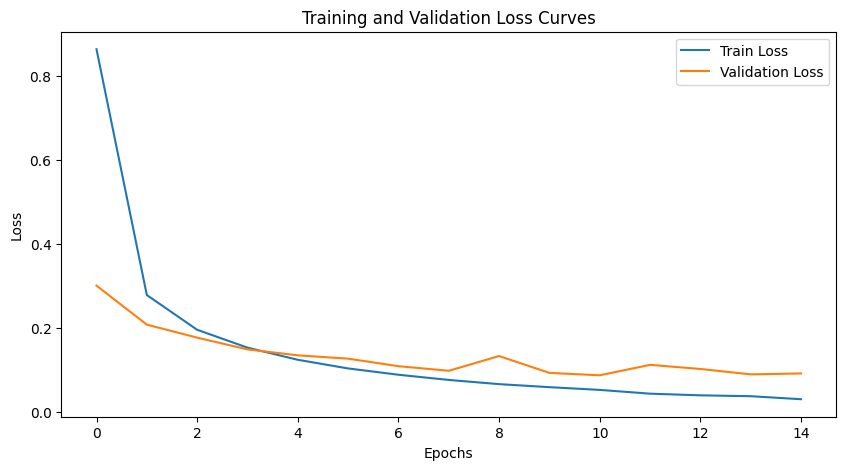

Test Accuracy: 97.71%


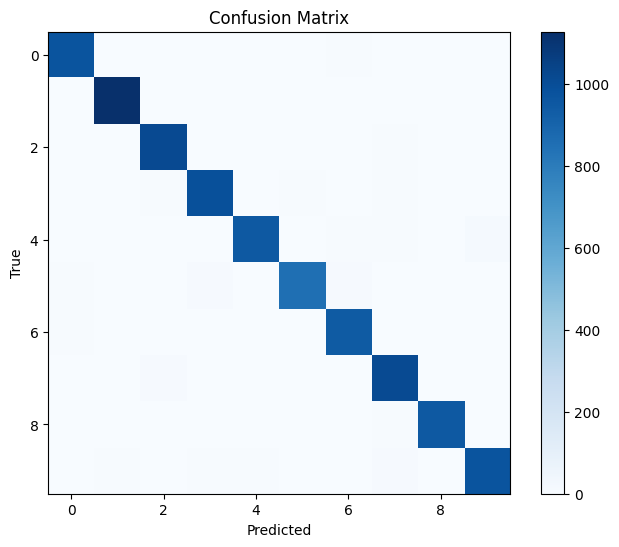

In [97]:
# Constants
input_size = 28 * 28
hidden_sizes = [500, 250, 100]
output_size = 10
learning_rate = 0.01
epochs = 15

# Constants
activation_function = "relu"  # Replace with the actual activation function used


# Create a unique directory name based on activation function and learning rate
log_dir = f"logs/{activation_function}_lr{learning_rate:.4f}_wi"

# Make sure the logs directory exists
os.makedirs(log_dir, exist_ok=True)

# Initialize the SummaryWriter with the unique log directory
writer = SummaryWriter(log_dir=log_dir)

# Create your NeuralNetwork model
model = NeuralNetwork(input_size, hidden_sizes, output_size)

# Create a list to store training and validation losses
train_losses = []
val_losses = []
# Training loop
# Training loop
for epoch in range(epochs):
    total_loss = 0
    for batch_images, batch_labels in train_loader:
        # Flatten the batch_images
        batch_images = batch_images.view(-1, input_size).numpy()
        # One-hot encode the batch_labels
        batch_labels_onehot = one_hot_encode(batch_labels, output_size).numpy()
        # Train the model on the batch
        model.train(batch_images, batch_labels_onehot, learning_rate)

    average_loss = model.total_loss / len(train_loader)
    model.total_loss = 0
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {average_loss:.4f}")

    # Log the training loss to TensorBoard and store it in the list
    writer.add_scalar('Loss/Train', average_loss, epoch)
    train_losses.append(average_loss)

    # Validation loop
    total_val_loss = 0
    num_val_batches = len(val_loader)

    for val_batch_images, val_batch_labels in val_loader:
        # Get predictions from the model
        val_batch_images = val_batch_images.view(-1, input_size).numpy()
        val_batch_labels_onehot = one_hot_encode(val_batch_labels, output_size).numpy()
        model.validate(val_batch_images, val_batch_labels_onehot)

    average_val_loss = model.total_loss / len(val_loader)
    model.total_loss = 0
    print(f"Epoch {epoch + 1}/{epochs}, Val Loss: {average_val_loss:.4f}")

    # Log the validation loss to TensorBoard and store it in the list
    writer.add_scalar('Loss/Validation', average_val_loss, epoch)
    val_losses.append(average_val_loss)

# Close the SummaryWriter
writer.close()

# Plotting training and validation loss curves
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Curves')
plt.savefig(os.path.join(log_dir, 'loss_plot.png'))
plt.show()

# Testing loop
correct = 0
total = 0
true_labels = []
predicted_labels = []

for batch_images, batch_labels in test_loader:
    batch_images = batch_images.view(-1, input_size).numpy()
    batch_labels_onehot = one_hot_encode(batch_labels, output_size).numpy()

    # Get predictions from the model
    predictions = model.predict(batch_images)
    true_labels.extend(batch_labels.numpy())
    predicted_labels.extend(predictions)

    # Calculate accuracy
    total += batch_labels.size(0)
    correct += (predictions == batch_labels.numpy()).sum().item()

accuracy = (100 * correct / total)
print(f"Test Accuracy: {accuracy:.2f}%")

# Generate and display the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig(os.path.join(log_dir, 'confusion_matrix.png'))
plt.show()

All activation funtions

Same Learning Rate

In [ ]:
# Define your NeuralNetwork class
class NeuralNetwork:
    def __init__(self, input_size, hidden_sizes, output_size):
        # Initialize network architecture
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.num_layers = len(hidden_sizes) + 1

        # Initialize weights and biases for all layers using Glorot initialization
        self.weights = []
        self.biases = []
        for i in range(len(hidden_sizes) + 1):
            if i == 0:
                M = np.sqrt(6.0 / (input_size + hidden_sizes[i]))
                self.weights.append(np.random.uniform(-M, M, size=(input_size, hidden_sizes[i])))
            elif i == len(hidden_sizes):
                M = np.sqrt(6.0 / (hidden_sizes[i - 1] + output_size))
                self.weights.append(np.random.uniform(-M, M, size=(hidden_sizes[i - 1], output_size)))
            else:
                M = np.sqrt(6.0 / (hidden_sizes[i - 1] + hidden_sizes[i]))
                self.weights.append(np.random.uniform(-M, M, size=(hidden_sizes[i - 1], hidden_sizes[i])))
            if i == len(hidden_sizes):
                bias_vector = np.zeros((1, self.output_size))
            else:
                bias_vector = np.zeros((1, hidden_sizes[i]))
            self.biases.append(bias_vector)

        self.total_loss = 0

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def tanh(self, x):
        return np.tanh(x)

    def relu(self, x):
        return np.maximum(0, x)

    def softmax(self, x):
        # Subtract the maximum value for each row for numerical stability
        max_x = np.max(x, axis=1, keepdims=True)
        exp_x = np.exp(x - max_x)
        return exp_x / exp_x.sum(axis=1, keepdims=True)
    def forward_pass(self, X, activation_function):
        activations = [X]
        for i in range(self.num_layers):
            z = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            if i == self.num_layers - 1:
                output = self.softmax(z)
                activations.append(output)
            else:
                if activation_function == "sigmoid":
                    activation = self.sigmoid(z)
                elif activation_function == "tanh":
                    activation = self.tanh(z)
                elif activation_function == "relu":
                    activation = self.relu(z)
                activations.append(activation)
        return activations

    def cross_entropy_loss(self, y_true, y_pred):
        epsilon = 1e-15  # Small constant to avoid log(0)
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        x = - y_true * np.log(y_pred)
        loss = np.sum(x, axis=1).mean()
        return loss  # Calculate the mean loss

    def backward_pass(self, X, y_true, activations, activation_function):
        gradients = []
        delta = activations[-1] - y_true
        for i in range(self.num_layers - 1, -1, -1):
            if i == self.num_layers - 1:
                dW = np.dot(activations[i].T, delta)
                db = np.sum(delta, axis=0, keepdims=True)
            else:
                if activation_function == "sigmoid":
                    delta = np.dot(delta, self.weights[i + 1].T) * activations[i + 1] * (1 - activations[i + 1])
                elif activation_function == "tanh":
                    delta = np.dot(delta, self.weights[i + 1].T) * (1 - activations[i + 1] ** 2)
                elif activation_function == "relu":
                    delta = np.dot(delta, self.weights[i + 1].T) * (activations[i + 1] > 0)
                dW = np.dot(activations[i].T, delta)
                db = np.sum(delta, axis=0, keepdims=True)
            gradients.insert(0, (dW, db))
        return gradients

    def update_weights(self, gradients, learning_rate):
        for i in range(self.num_layers):
            self.weights[i] -= learning_rate * gradients[i][0]
            self.biases[i] -= learning_rate * gradients[i][1]

    def train(self, X_batch, y_batch, learning_rate, activation_function):
        total_loss = 0
        activations = self.forward_pass(X_batch, activation_function)
        loss = self.cross_entropy_loss(y_batch, activations[-1])
        gradients = self.backward_pass(X_batch, y_batch, activations, activation_function)
        self.update_weights(gradients, learning_rate)
        self.total_loss += loss
        total_loss += loss
        average_loss = total_loss / len(X_batch)

    def validate(self, X_batch, y_batch, activation_function):
        total_loss = 0
        activations = self.forward_pass(X_batch, activation_function)
        loss = self.cross_entropy_loss(y_batch, activations[-1])
        self.total_loss += loss
        total_loss += loss
        average_loss = total_loss / len(X_batch)

    def predict(self, X, activation_function):
        activations = self.forward_pass(X, activation_function)
        return np.argmax(activations[-1], axis=1)

In [ ]:
# Initialize the SummaryWriter
writer = SummaryWriter()

# Constants
input_size = 28 * 28
hidden_sizes = [500, 250, 100]
output_size = 10
learning_rate = 0.01
epochs = 15

# Create your NeuralNetwork model for different activation functions
model_sigmoid = NeuralNetwork(input_size, hidden_sizes, output_size)
model_tanh = NeuralNetwork(input_size, hidden_sizes, output_size)
model_relu = NeuralNetwork(input_size, hidden_sizes, output_size)


for epoch in range(epochs):
    # Training with Tanh activation
    total_loss_tanh = 0

    for batch_images, batch_labels in train_loader:
        batch_images = batch_images.view(-1, input_size).numpy()
        batch_labels_onehot = one_hot_encode(batch_labels, output_size).numpy()
        model_tanh.train(batch_images, batch_labels_onehot, learning_rate, activation_function="tanh")
    total_loss_tanh = model_tanh.total_loss
    model_tanh.total_loss = 0
    average_train_loss_tanh = total_loss_tanh/ len(train_loader)
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss (Tanh): {average_train_loss_tanh:.4f}")

    # Log the training loss for Tanh
    writer.add_scalar('Training Loss (Tanh)', average_train_loss_tanh, epoch)

    # Validation with Tanh activation

    total_val_loss_tanh = 0

    for val_batch_images, val_batch_labels in val_loader:
        val_batch_images = val_batch_images.view(-1, input_size).numpy()
        val_batch_labels_onehot = one_hot_encode(val_batch_labels, output_size).numpy()
        model_tanh.validate(val_batch_images, val_batch_labels_onehot, activation_function="tanh")

    total_val_loss_tanh = model_tanh.total_loss
    model_tanh.total_loss = 0
    average_val_loss_tanh = total_val_loss_tanh / len(val_loader)
    print(f"Epoch {epoch + 1}/{epochs}, Val Loss (Tanh): {average_val_loss_tanh:.4f}")

    # Log the validation loss for Tanh
    writer.add_scalar('Validation Loss (Tanh)', average_val_loss_tanh, epoch)



    # Training with Sigmoid activation
    total_loss_sigmoid = 0

    for batch_images, batch_labels in train_loader:
        batch_images = batch_images.view(-1, input_size).numpy()
        batch_labels_onehot = one_hot_encode(batch_labels, output_size).numpy()
        model_sigmoid.train(batch_images, batch_labels_onehot, learning_rate, activation_function="sigmoid")

    total_loss_sigmoid = model_sigmoid.total_loss
    model_sigmoid.total_loss = 0
    average_train_loss_sigmoid = total_loss_sigmoid / len(train_loader)
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss (Sigmoid): {average_train_loss_sigmoid:.4f}")

    # Log the training loss for Sigmoid
    writer.add_scalar('Training Loss (Sigmoid)', average_train_loss_sigmoid, epoch)

    # Validation with Sigmoid activation

    total_val_loss_sigmoid = 0

    for val_batch_images, val_batch_labels in val_loader:
        val_batch_images = val_batch_images.view(-1, input_size).numpy()
        val_batch_labels_onehot = one_hot_encode(val_batch_labels, output_size).numpy()
        model_sigmoid.validate(val_batch_images, val_batch_labels_onehot, activation_function="sigmoid")

    total_val_loss_sigmoid = model_sigmoid.total_loss
    model_sigmoid.total_loss = 0
    average_val_loss_sigmoid = total_val_loss_sigmoid / len(val_loader)
    print(f"Epoch {epoch + 1}/{epochs}, Val Loss (Sigmoid): {average_val_loss_sigmoid:.4f}")

    # Log the validation loss for Sigmoid
    writer.add_scalar('Validation Loss (Sigmoid)', average_val_loss_sigmoid, epoch)

    # Training with ReLU activation

    total_loss_relu = 0

    for batch_images, batch_labels in train_loader:
        batch_images = batch_images.view(-1, input_size).numpy()
        batch_labels_onehot = one_hot_encode(batch_labels, output_size).numpy()
        model_relu.train(batch_images, batch_labels_onehot, learning_rate, activation_function="relu")

    total_loss_relu = model_relu.total_loss
    model_relu.total_loss = 0
    average_train_loss_relu = total_loss_relu / len(train_loader)
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss (ReLU): {average_train_loss_relu:.4f}")

    # Log the training loss for ReLU
    writer.add_scalar('Training Loss (ReLU)', average_train_loss_relu, epoch)

    # Validation with ReLU activation

    total_val_loss_relu = 0

    for val_batch_images, val_batch_labels in val_loader:
        val_batch_images = val_batch_images.view(-1, input_size).numpy()
        val_batch_labels_onehot = one_hot_encode(val_batch_labels, output_size).numpy()
        model_relu.validate(val_batch_images, val_batch_labels_onehot, activation_function="relu")

    total_val_loss_relu = model_relu.total_loss
    model_relu.total_loss = 0
    average_val_loss_relu = total_val_loss_relu / len(val_loader)
    print(f"Epoch {epoch + 1}/{epochs}, Val Loss (ReLU): {average_val_loss_relu:.4f}")

    # Log the validation loss for ReLU
    writer.add_scalar('Validation Loss (ReLU)', average_val_loss_relu, epoch)



# Testing loop for different activation functions (continued)
correct_sigmoid = 0
correct_tanh = 0
correct_relu = 0
total = 0

for batch_images, batch_labels in test_loader:
    batch_images = batch_images.view(-1, input_size).numpy()
    batch_labels_onehot = one_hot_encode(batch_labels, output_size).numpy()

    # Get predictions from each model
    predictions_sigmoid = model_sigmoid.predict(batch_images, activation_function="sigmoid")
    predictions_tanh = model_tanh.predict(batch_images, activation_function="tanh")
    predictions_relu = model_relu.predict(batch_images, activation_function="relu")

    # Calculate accuracy for each model
    total += batch_labels.size(0)
    correct_sigmoid += (predictions_sigmoid == batch_labels.numpy()).sum().item()
    correct_tanh += (predictions_tanh == batch_labels.numpy()).sum().item()
    correct_relu += (predictions_relu == batch_labels.numpy()).sum().item()

accuracy_sigmoid = (100 * correct_sigmoid / total)
accuracy_tanh = (100 * correct_tanh / total)
accuracy_relu = (100 * correct_relu / total)

print(f"Test Accuracy (Sigmoid): {accuracy_sigmoid:.2f}%")
print(f"Test Accuracy (Tanh): {accuracy_tanh:.2f}%")
print(f"Test Accuracy (ReLU): {accuracy_relu:.2f}%")

# Close the SummaryWriter
writer.close()


Epoch 1/15, Train Loss (Tanh): 19.9952
Epoch 1/15, Val Loss (Tanh): 20.5106
Epoch 1/15, Train Loss (Sigmoid): 0.8618
Epoch 1/15, Val Loss (Sigmoid): 0.3383
Epoch 1/15, Train Loss (ReLU): 2.7253
Epoch 1/15, Val Loss (ReLU): 2.3021
Epoch 2/15, Train Loss (Tanh): 20.0874
Epoch 2/15, Val Loss (Tanh): 17.7611
Epoch 2/15, Train Loss (Sigmoid): 0.2790
Epoch 2/15, Val Loss (Sigmoid): 0.2201
Epoch 2/15, Train Loss (ReLU): 2.3037
Epoch 2/15, Val Loss (ReLU): 2.3052
Epoch 3/15, Train Loss (Tanh): 20.1846
Epoch 3/15, Val Loss (Tanh): 15.2132
Epoch 3/15, Train Loss (Sigmoid): 0.1949
Epoch 3/15, Val Loss (Sigmoid): 0.1602
Epoch 3/15, Train Loss (ReLU): 2.3038
Epoch 3/15, Val Loss (ReLU): 2.3013
Epoch 4/15, Train Loss (Tanh): 20.5211
Epoch 4/15, Val Loss (Tanh): 17.8225
Epoch 4/15, Train Loss (Sigmoid): 0.1502
Epoch 4/15, Val Loss (Sigmoid): 0.1306
Epoch 4/15, Train Loss (ReLU): 2.3034
Epoch 4/15, Val Loss (ReLU): 2.3032
Epoch 5/15, Train Loss (Tanh): 20.1110
Epoch 5/15, Val Loss (Tanh): 17.7385
Epoc

Tuned Learning Rates

In [ ]:
# Initialize the SummaryWriter
writer = SummaryWriter()

# Constants
input_size = 28 * 28
hidden_sizes = [500, 250, 100]
output_size = 10
epochs = 15

# Define different learning rates for each activation function
learning_rate_tanh = 0.001  # Change this to your desired learning rate for Tanh
learning_rate_sigmoid = 0.01  # Change this to your desired learning rate for Sigmoid
learning_rate_relu = 0.001  # Change this to your desired learning rate for ReLU

# Create your NeuralNetwork model for different activation functions
model_tanh = NeuralNetwork(input_size, hidden_sizes, output_size)
model_sigmoid = NeuralNetwork(input_size, hidden_sizes, output_size)
model_relu = NeuralNetwork(input_size, hidden_sizes, output_size)

for epoch in range(epochs):
    # Training with Tanh activation
    total_loss_tanh = 0

    for batch_images, batch_labels in train_loader:
        batch_images = batch_images.view(-1, input_size).numpy()
        batch_labels_onehot = one_hot_encode(batch_labels, output_size).numpy()
        model_tanh.train(batch_images, batch_labels_onehot, learning_rate_tanh, activation_function="tanh")

    total_loss_tanh = model_tanh.total_loss
    model_tanh.total_loss = 0
    average_train_loss_tanh = total_loss_tanh / len(train_loader)
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss (Tanh): {average_train_loss_tanh:.4f}")

    # Log the training loss for Tanh
    writer.add_scalar('Training Loss (Tanh)', average_train_loss_tanh, epoch)

    # Validation with Tanh activation
    total_val_loss_tanh = 0

    for val_batch_images, val_batch_labels in val_loader:
        val_batch_images = val_batch_images.view(-1, input_size).numpy()
        val_batch_labels_onehot = one_hot_encode(val_batch_labels, output_size).numpy()
        model_tanh.validate(val_batch_images, val_batch_labels_onehot, activation_function="tanh")

    total_val_loss_tanh = model_tanh.total_loss
    model_tanh.total_loss = 0
    average_val_loss_tanh = total_val_loss_tanh / len(val_loader)
    print(f"Epoch {epoch + 1}/{epochs}, Val Loss (Tanh): {average_val_loss_tanh:.4f}")

    # Log the validation loss for Tanh
    writer.add_scalar('Validation Loss (Tanh)', average_val_loss_tanh, epoch)

    # Training with Sigmoid activation
    total_loss_sigmoid = 0

    for batch_images, batch_labels in train_loader:
        batch_images = batch_images.view(-1, input_size).numpy()
        batch_labels_onehot = one_hot_encode(batch_labels, output_size).numpy()
        model_sigmoid.train(batch_images, batch_labels_onehot, learning_rate_sigmoid, activation_function="sigmoid")

    total_loss_sigmoid = model_sigmoid.total_loss
    model_sigmoid.total_loss = 0
    average_train_loss_sigmoid = total_loss_sigmoid / len(train_loader)
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss (Sigmoid): {average_train_loss_sigmoid:.4f}")

    # Log the training loss for Sigmoid
    writer.add_scalar('Training Loss (Sigmoid)', average_train_loss_sigmoid, epoch)

    # Validation with Sigmoid activation
    total_val_loss_sigmoid = 0

    for val_batch_images, val_batch_labels in val_loader:
        val_batch_images = val_batch_images.view(-1, input_size).numpy()
        val_batch_labels_onehot = one_hot_encode(val_batch_labels, output_size).numpy()
        model_sigmoid.validate(val_batch_images, val_batch_labels_onehot, activation_function="sigmoid")

    total_val_loss_sigmoid = model_sigmoid.total_loss
    model_sigmoid.total_loss = 0
    average_val_loss_sigmoid = total_val_loss_sigmoid / len(val_loader)
    print(f"Epoch {epoch + 1}/{epochs}, Val Loss (Sigmoid): {average_val_loss_sigmoid:.4f}")

    # Log the validation loss for Sigmoid
    writer.add_scalar('Validation Loss (Sigmoid)', average_val_loss_sigmoid, epoch)

    # Training with ReLU activation
    total_loss_relu = 0

    for batch_images, batch_labels in train_loader:
        batch_images = batch_images.view(-1, input_size).numpy()
        batch_labels_onehot = one_hot_encode(batch_labels, output_size).numpy()
        model_relu.train(batch_images, batch_labels_onehot, learning_rate_relu, activation_function="relu")

    total_loss_relu = model_relu.total_loss
    model_relu.total_loss = 0
    average_train_loss_relu = total_loss_relu / len(train_loader)
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss (ReLU): {average_train_loss_relu:.4f}")

    # Log the training loss for ReLU
    writer.add_scalar('Training Loss (ReLU)', average_train_loss_relu, epoch)

    # Validation with ReLU activation
    total_val_loss_relu = 0

    for val_batch_images, val_batch_labels in val_loader:
        val_batch_images = val_batch_images.view(-1, input_size).numpy()
        val_batch_labels_onehot = one_hot_encode(val_batch_labels, output_size).numpy()
        model_relu.validate(val_batch_images, val_batch_labels_onehot, activation_function="relu")

    total_val_loss_relu = model_relu.total_loss
    model_relu.total_loss = 0
    average_val_loss_relu = total_val_loss_relu / len(val_loader)
    print(f"Epoch {epoch + 1}/{epochs}, Val Loss (ReLU): {average_val_loss_relu:.4f}")

    # Log the validation loss for ReLU
    writer.add_scalar('Validation Loss (ReLU)', average_val_loss_relu, epoch)

# Testing loop and accuracy calculation for different activation functions (unchanged)

# Close the SummaryWriter
writer.close()


Epoch 1/15, Train Loss (Tanh): 0.3885
Epoch 1/15, Val Loss (Tanh): 0.2121
Epoch 1/15, Train Loss (Sigmoid): 0.8646
Epoch 1/15, Val Loss (Sigmoid): 0.3556
Epoch 1/15, Train Loss (ReLU): 0.4148
Epoch 1/15, Val Loss (ReLU): 0.1965
Epoch 2/15, Train Loss (Tanh): 0.1801
Epoch 2/15, Val Loss (Tanh): 0.1642
Epoch 2/15, Train Loss (Sigmoid): 0.2757
Epoch 2/15, Val Loss (Sigmoid): 0.2627
Epoch 2/15, Train Loss (ReLU): 0.1593
Epoch 2/15, Val Loss (ReLU): 0.1361
Epoch 3/15, Train Loss (Tanh): 0.1304
Epoch 3/15, Val Loss (Tanh): 0.1311
Epoch 3/15, Train Loss (Sigmoid): 0.1944
Epoch 3/15, Val Loss (Sigmoid): 0.1826
Epoch 3/15, Train Loss (ReLU): 0.1124
Epoch 3/15, Val Loss (ReLU): 0.1233
Epoch 4/15, Train Loss (Tanh): 0.1010
Epoch 4/15, Val Loss (Tanh): 0.1242
Epoch 4/15, Train Loss (Sigmoid): 0.1502
Epoch 4/15, Val Loss (Sigmoid): 0.1854
Epoch 4/15, Train Loss (ReLU): 0.0872
Epoch 4/15, Val Loss (ReLU): 0.1086
Epoch 5/15, Train Loss (Tanh): 0.0825
Epoch 5/15, Val Loss (Tanh): 0.1026
Epoch 5/15, Tr

In [ ]:
# Testing loop for different activation functions (continued)
correct_sigmoid = 0
correct_tanh = 0
correct_relu = 0
total = 0

for batch_images, batch_labels in test_loader:
    batch_images = batch_images.view(-1, input_size).numpy()
    batch_labels_onehot = one_hot_encode(batch_labels, output_size).numpy()

    # Get predictions from each model
    predictions_sigmoid = model_sigmoid.predict(batch_images, activation_function="sigmoid")
    predictions_tanh = model_tanh.predict(batch_images, activation_function="tanh")
    predictions_relu = model_relu.predict(batch_images, activation_function="relu")

    # Calculate accuracy for each model
    total += batch_labels.size(0)
    correct_sigmoid += (predictions_sigmoid == batch_labels.numpy()).sum().item()
    correct_tanh += (predictions_tanh == batch_labels.numpy()).sum().item()
    correct_relu += (predictions_relu == batch_labels.numpy()).sum().item()

accuracy_sigmoid = (100 * correct_sigmoid / total)
accuracy_tanh = (100 * correct_tanh / total)
accuracy_relu = (100 * correct_relu / total)

print(f"Test Accuracy (Sigmoid): {accuracy_sigmoid:.2f}%")
print(f"Test Accuracy (Tanh): {accuracy_tanh:.2f}%")
print(f"Test Accuracy (ReLU): {accuracy_relu:.2f}%")


Test Accuracy (Sigmoid): 97.71%
Test Accuracy (Tanh): 97.59%
Test Accuracy (ReLU): 98.05%


**Inferences**

Weight Initialization

Weight Intialization makes convergence faster can be seen with the loss at zeroth epoch.


Activation Function

ReLU > Sigmoid > Tanh after finetuning Learning Rate. This alings with the general trend.
However it can be noted that ideal learning rates for different actvations are different.

Confusion Matrix

5 is the most missclassified number and it misclassified as 9 which is expected are they differ in 1 line only.
1 is the easiest to classify which also expected.


**Package with ReLU**

Epoch [1/15] Train Loss: 1.6569714872231824
Epoch [1/15] Validation Loss: 1.564999318652683
Epoch [2/15] Train Loss: 1.538306500266344
Epoch [2/15] Validation Loss: 1.5319475142161052
Epoch [3/15] Train Loss: 1.5192086853787072
Epoch [3/15] Validation Loss: 1.5183522107866074
Epoch [4/15] Train Loss: 1.5086149845016288
Epoch [4/15] Validation Loss: 1.5134225532743666
Epoch [5/15] Train Loss: 1.5020115688171494
Epoch [5/15] Validation Loss: 1.5132947015762328
Epoch [6/15] Train Loss: 1.4977878385640127
Epoch [6/15] Validation Loss: 1.498897485203213
Epoch [7/15] Train Loss: 1.4923318158025327
Epoch [7/15] Validation Loss: 1.4961671373579237
Epoch [8/15] Train Loss: 1.4902256518226185
Epoch [8/15] Validation Loss: 1.4945245949427286
Epoch [9/15] Train Loss: 1.4871337193091823
Epoch [9/15] Validation Loss: 1.4925214253531562
Epoch [10/15] Train Loss: 1.485942777376857
Epoch [10/15] Validation Loss: 1.4914808162053426
Epoch [11/15] Train Loss: 1.4840754474530213
Epoch [11/15] Validation Lo

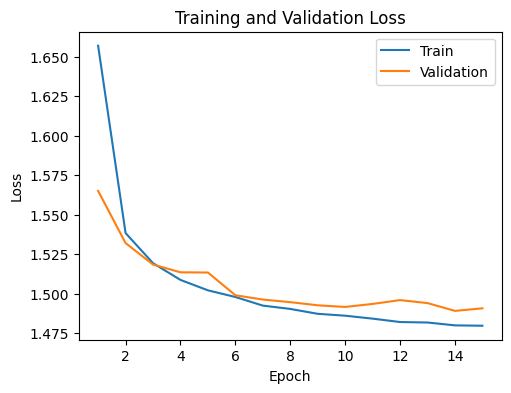

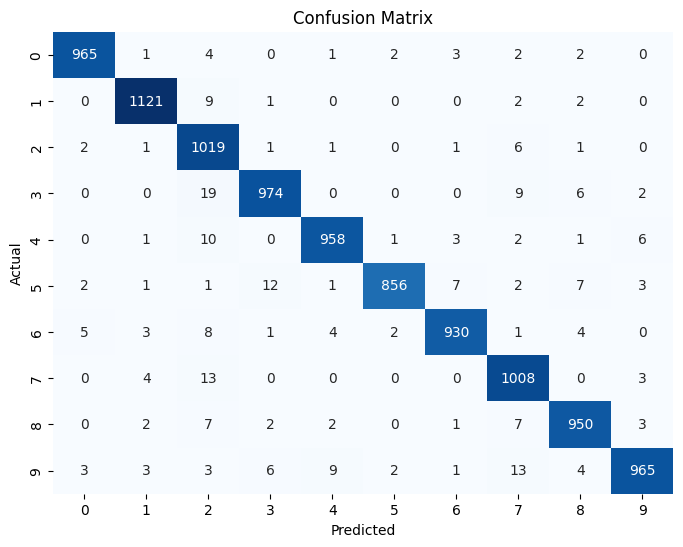

In [93]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torch.nn.init as init
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Define the Neural Network class
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 500)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(500, 250)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(250, 100)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(100, 10)  # Output layer
        self.softmax = nn.Softmax(dim=1)

        # Initialize weights using Glorot Initialization
        for layer in [self.fc1, self.fc2, self.fc3, self.fc4]:
            if isinstance(layer, nn.Linear):
                init.xavier_uniform_(layer.weight)
                init.zeros_(layer.bias)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        x = self.softmax(x)
        return x

# Define a function to check if GPU is available
def get_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
input_size = 28 * 28
learning_rate = 0.0002
batch_size = 64
num_epochs = 15

# Create the model and move it to the appropriate device
device = get_device()
model = NeuralNetwork().to(device)
criterion = nn.CrossEntropyLoss()

# Create an optimizer with L2 regularization (weight decay)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Create a directory for TensorBoard logs
log_dir = "./logs"
writer = SummaryWriter(log_dir)

# Training loop
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    #model.train()
    running_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Log the loss to TensorBoard
        writer.add_scalar('Loss/train', loss.item(), epoch * len(train_loader) + batch_idx)

    print(f'Epoch [{epoch + 1}/{num_epochs}] Train Loss: {running_loss / len(train_loader)}')
    train_losses.append(running_loss / len(train_loader))  # Append the training loss

    # Validation loop
    #model.eval()  # Set the model to evaluation mode
    val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    # Calculate the average validation loss
    average_val_loss = val_loss / len(val_loader)

    # Log the validation loss to TensorBoard
    writer.add_scalar('Loss/val', average_val_loss, epoch)
    val_losses.append(average_val_loss)  # Append the validation loss

    print(f'Epoch [{epoch + 1}/{num_epochs}] Validation Loss: {average_val_loss}')

# Close the TensorBoard writer
writer.close()

# Plot training and validation losses
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Evaluate the model on the test dataset
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on the test dataset: {accuracy:.2f}%')

# Plot confusion matrix
all_labels = []
all_predicted = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())

confusion = confusion_matrix(all_labels, all_predicted)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Epoch [1/15] Train Loss: 1.7108755233745923
Epoch [1/15] Validation Loss: 1.6171336444218953
Epoch [2/15] Train Loss: 1.6134174553909943
Epoch [2/15] Validation Loss: 1.6004756757948133
Epoch [3/15] Train Loss: 1.5481133347306646
Epoch [3/15] Validation Loss: 1.5202491230434843
Epoch [4/15] Train Loss: 1.5079821548823054
Epoch [4/15] Validation Loss: 1.511709041595459
Epoch [5/15] Train Loss: 1.5006688258089491
Epoch [5/15] Validation Loss: 1.4994775496588812
Epoch [6/15] Train Loss: 1.4958215545638247
Epoch [6/15] Validation Loss: 1.5012267780303956
Epoch [7/15] Train Loss: 1.4925845308022947
Epoch [7/15] Validation Loss: 1.497010776731703
Epoch [8/15] Train Loss: 1.4899416168809438
Epoch [8/15] Validation Loss: 1.4974490658442179
Epoch [9/15] Train Loss: 1.4873300386177373
Epoch [9/15] Validation Loss: 1.4919867526160346
Epoch [10/15] Train Loss: 1.4847918671946372
Epoch [10/15] Validation Loss: 1.4930877251095243
Epoch [11/15] Train Loss: 1.4834039982037324
Epoch [11/15] Validation 

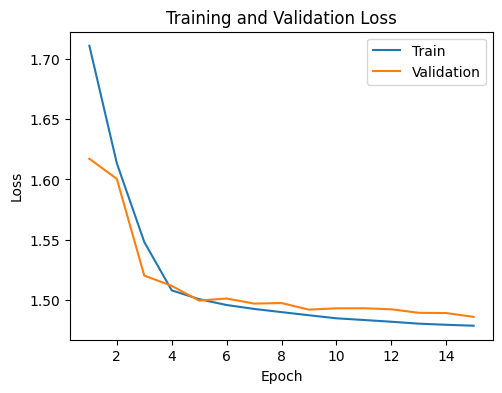

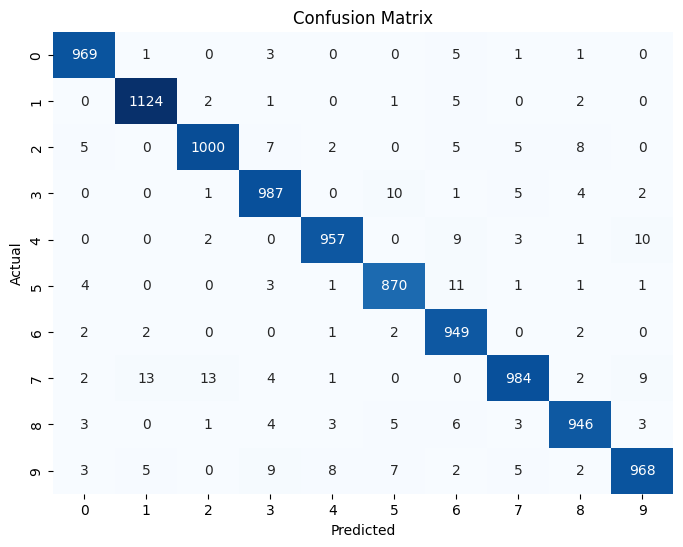

In [105]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torch.nn.init as init
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Define the Neural Network class
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 500)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(500, 250)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(250, 100)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(100, 10)  # Output layer
        self.softmax = nn.Softmax(dim=1)

        # Initialize weights using Glorot Initialization
        for layer in [self.fc1, self.fc2, self.fc3, self.fc4]:
            if isinstance(layer, nn.Linear):
                init.xavier_uniform_(layer.weight)
                init.zeros_(layer.bias)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        x = self.softmax(x)
        return x

# Define a function to check if GPU is available
def get_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
input_size = 28 * 28
learning_rate = 0.0002
batch_size = 64
num_epochs = 15
weight_decay = 0.1*1e-5  # L2 regularization strength

# Create the model and move it to the appropriate device
device = get_device()
model = NeuralNetwork().to(device)
criterion = nn.CrossEntropyLoss()

# Create an optimizer with L2 regularization (weight decay)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Create a directory for TensorBoard logs
log_dir = "./logs"
writer = SummaryWriter(log_dir)

# Training loop
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    #model.train()
    running_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Log the loss to TensorBoard
        writer.add_scalar('Loss/train', loss.item(), epoch * len(train_loader) + batch_idx)

    print(f'Epoch [{epoch + 1}/{num_epochs}] Train Loss: {running_loss / len(train_loader)}')
    train_losses.append(running_loss / len(train_loader))  # Append the training loss

    # Validation loop
    #model.eval()  # Set the model to evaluation mode
    val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    # Calculate the average validation loss
    average_val_loss = val_loss / len(val_loader)

    # Log the validation loss to TensorBoard
    writer.add_scalar('Loss/val', average_val_loss, epoch)
    val_losses.append(average_val_loss)  # Append the validation loss

    print(f'Epoch [{epoch + 1}/{num_epochs}] Validation Loss: {average_val_loss}')

# Close the TensorBoard writer
writer.close()

# Plot training and validation losses
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Evaluate the model on the test dataset
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on the test dataset: {accuracy:.2f}%')

# Plot confusion matrix
all_labels = []
all_predicted = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())

confusion = confusion_matrix(all_labels, all_predicted)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


**Regularization**

In case of ReLU, Regularization improves accuracy as we can see that model starts  overfitting under 15 epochs without Regularization

We can still observe that ReLU is better than Sigmoid both with and without regularization

Sigmoid with Package

In [ ]:
import torch.nn.init as init

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 500)
        self.sigmoid1 = nn.Sigmoid()
        self.fc2 = nn.Linear(500, 250)
        self.sigmoid2 = nn.Sigmoid()
        self.fc3 = nn.Linear(250, 100)
        self.sigmoid3 = nn.Sigmoid()
        self.fc4 = nn.Linear(100, 10)  # Output layer
        self.softmax = nn.Softmax(dim=1)

        # Initialize weights using Glorot Initialization
        for layer in [self.fc1, self.fc2, self.fc3, self.fc4]:
            if isinstance(layer, nn.Linear):
                init.xavier_uniform_(layer.weight)
                init.zeros_(layer.bias)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.sigmoid1(x)
        x = self.fc2(x)
        x = self.sigmoid2(x)
        x = self.fc3(x)
        x = self.sigmoid3(x)
        x = self.fc4(x)
        x = self.softmax(x)
        return x

# Define a function to check if GPU is available
def get_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Hyperparameters
input_size = 28 * 28
learning_rate = 0.001
batch_size = 64
num_epochs = 15

# Create the model and define loss and optimizer
model = NeuralNetwork()
# Create the model and move it to the appropriate device
device = get_device()
model = NeuralNetwork().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
num_classes = 10
# Create a directory for TensorBoard logs
log_dir = "./logs"
writer = SummaryWriter(log_dir)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        labels_onehot = one_hot_encode(labels,num_classes)
        loss = criterion(outputs, labels_onehot)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Log the loss to TensorBoard
        writer.add_scalar('Loss/train', loss.item(), epoch * len(train_loader) + batch_idx)

    print(f'Epoch [{epoch + 1}/{num_epochs}] Train Loss: {running_loss / len(train_loader)}')
# Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            labels_onehot = one_hot_encode(labels,num_classes)
            loss = criterion(outputs, labels_onehot)
            val_loss += loss.item()

    # Calculate the average validation loss
    average_val_loss = val_loss / len(val_loader)

    # Log the validation loss to TensorBoard
    writer.add_scalar('Loss/val', average_val_loss, epoch)

    print(f'Epoch [{epoch + 1}/{num_epochs}] Validation Loss: {average_val_loss}')

# Close the TensorBoard writer
writer.close()


model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on the test dataset: {accuracy:.2f}%')


Epoch [1/15] Train Loss: 1.7747530084505656
Epoch [1/15] Validation Loss: 1.648273975054423
Epoch [2/15] Train Loss: 1.6203086846005197
Epoch [2/15] Validation Loss: 1.5407604402965969
Epoch [3/15] Train Loss: 1.534938049517039
Epoch [3/15] Validation Loss: 1.52858213212755
Epoch [4/15] Train Loss: 1.518556594514245
Epoch [4/15] Validation Loss: 1.5202671024534438
Epoch [5/15] Train Loss: 1.51062828728728
Epoch [5/15] Validation Loss: 1.512356350686815
Epoch [6/15] Train Loss: 1.5055348634051073
Epoch [6/15] Validation Loss: 1.5112913873460558
Epoch [7/15] Train Loss: 1.5029741366815768
Epoch [7/15] Validation Loss: 1.515186799367269
Epoch [8/15] Train Loss: 1.498806030519547
Epoch [8/15] Validation Loss: 1.512680130534702
Epoch [9/15] Train Loss: 1.498370342301453
Epoch [9/15] Validation Loss: 1.4983909299638536
Epoch [10/15] Train Loss: 1.4954688268155905
Epoch [10/15] Validation Loss: 1.5045906088087293
Epoch [11/15] Train Loss: 1.4935750901113887
Epoch [11/15] Validation Loss: 1.50

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torch.nn.init as init

# Define the Neural Network class
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 500)
        self.sigmoid1 = nn.Sigmoid()
        self.fc2 = nn.Linear(500, 250)
        self.sigmoid2 = nn.Sigmoid()
        self.fc3 = nn.Linear(250, 100)
        self.sigmoid3 = nn.Sigmoid()
        self.fc4 = nn.Linear(100, 10)  # Output layer
        self.softmax = nn.Softmax(dim=1)

        # Initialize weights using Glorot Initialization
        for layer in [self.fc1, self.fc2, self.fc3, self.fc4]:
            if isinstance(layer, nn.Linear):
                init.xavier_uniform_(layer.weight)
                init.zeros_(layer.bias)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.sigmoid1(x)
        x = self.fc2(x)
        x = self.sigmoid2(x)
        x = self.fc3(x)
        x = self.sigmoid3(x)
        x = self.fc4(x)
        x = self.softmax(x)
        return x

# Define a function to check if GPU is available
def get_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
input_size = 28 * 28
learning_rate = 0.001
batch_size = 64
num_epochs = 15
weight_decay = 1e-6  # L2 regularization strength

# Create the model and move it to the appropriate device
device = get_device()
model = NeuralNetwork().to(device)
criterion = nn.CrossEntropyLoss()

# Create an optimizer with L2 regularization (weight decay)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Create a directory for TensorBoard logs
log_dir = "./logs"
writer = SummaryWriter(log_dir)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Log the loss to TensorBoard
        writer.add_scalar('Loss/train', loss.item(), epoch * len(train_loader) + batch_idx)

    print(f'Epoch [{epoch + 1}/{num_epochs}] Train Loss: {running_loss / len(train_loader)}')

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    # Calculate the average validation loss
    average_val_loss = val_loss / len(val_loader)

    # Log the validation loss to TensorBoard
    writer.add_scalar('Loss/val', average_val_loss, epoch)

    print(f'Epoch [{epoch + 1}/{num_epochs}] Validation Loss: {average_val_loss}')

# Close the TensorBoard writer
writer.close()

# Evaluate the model on the test dataset
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on the test dataset: {accuracy:.2f}%')


Epoch [1/15] Train Loss: 1.77970362144299
Epoch [1/15] Validation Loss: 1.6254331413904826
Epoch [2/15] Train Loss: 1.573421405709308
Epoch [2/15] Validation Loss: 1.5354119443893433
Epoch [3/15] Train Loss: 1.5258780385133761
Epoch [3/15] Validation Loss: 1.5233501031663683
Epoch [4/15] Train Loss: 1.5146148586005683
Epoch [4/15] Validation Loss: 1.5207502894931368
Epoch [5/15] Train Loss: 1.5079762857057268
Epoch [5/15] Validation Loss: 1.51431198226081
Epoch [6/15] Train Loss: 1.5033931727161916
Epoch [6/15] Validation Loss: 1.5186205662621393
Epoch [7/15] Train Loss: 1.5026500089640036
Epoch [7/15] Validation Loss: 1.509902957810296
Epoch [8/15] Train Loss: 1.4990829124022667
Epoch [8/15] Validation Loss: 1.5001370276345147
Epoch [9/15] Train Loss: 1.496729049408419
Epoch [9/15] Validation Loss: 1.5039297919803196
Epoch [10/15] Train Loss: 1.4953659393342649
Epoch [10/15] Validation Loss: 1.5066184277004666
Epoch [11/15] Train Loss: 1.4946540584069314
Epoch [11/15] Validation Loss: